In [106]:

"""
This file is containing a class, that perform all modules for 
Hovagim Bakardjian system that serves for feature extraction and command
classification in SSVEP based BCI. 

"""

import aseegg as ag
import numpy as np
import pandas as pd
from bieg import ICAManager
import matplotlib.pyplot as plt
import math
import scipy.signal as sig
from scipy.stats import mode

#good set of components to exclude: 0,14,27,28,127

class BakardjianSystem(object):
    
    def __init__(self,path,seconds,components_to_exclude = [0,14,27,28,127],s_08Hz=np.zeros(1),
                s_14Hz = np.zeros(1),s_28Hz = np.zeros(1),es_08Hz = np.zeros(1),
                es_14Hz = np.zeros(1),es_28Hz = np.zeros(1),dset = np.zeros(((15,256,128))),chunk = 1,
                extract = True):
        self.path = path
        self.seconds = seconds
        self.ica_file = ICAManager(input_path=self.path,method='fastica',sep=' ')
        self.components_to_exclude = components_to_exclude
        self.s_08Hz = s_08Hz
        self.s_14Hz = s_14Hz
        self.s_28Hz = s_28Hz
        self.es_08Hz = es_08Hz
        self.es_14Hz = es_14Hz
        self.es_28Hz = es_28Hz
        self.extract = extract
        
    #Module 1: Blind Source Separation/ICA 
    def bss_ica(self):
        self.ica_file.load_data()
        if self.extract == True:
            self.ica_file.extract_components()
            self.ica_file.exclude_ica_components(components_to_exclude=self.components_to_exclude)
        return self.ica_file
    
    #Module 2: Narrow-band filters
        
    def bank_of_filters(self):
    
        ica_file = self.ica_file
        
        electrode_O1 = ica_file.data[15]
        electrode_0z = ica_file.data[23]
        electrode_O2 = ica_file.data[28]

        prefiltered = [electrode_0z,electrode_O1,electrode_O2]

        #Signals filtered:

        self.s_08Hz = np.zeros((3,len(electrode_O1)))
        self.s_14Hz = np.zeros((3,len(electrode_O1)))
        self.s_28Hz = np.zeros((3,len(electrode_O1)))

        for n in range(0,3):
            signal_filtered_08Hz = ag.pasmowoprzepustowy(prefiltered[n],czestOdciecia1=7.9,czestOdciecia2=8.1,czestProbkowania=256)
            signal_filtered_14Hz = ag.pasmowoprzepustowy(prefiltered[n],czestOdciecia1=13.9,czestOdciecia2=14.1,czestProbkowania=256)
            signal_filtered_28Hz = ag.pasmowoprzepustowy(prefiltered[n],czestOdciecia1=27.9,czestOdciecia2=28.1,czestProbkowania=256)
            self.s_08Hz[n] = signal_filtered_08Hz
            self.s_14Hz[n] = signal_filtered_14Hz
            self.s_28Hz[n] = signal_filtered_28Hz
            
        return self.s_08Hz, self.s_14Hz, self.s_28Hz
        
    #Module3: Variance analyzer
        
    def variance_analyzer(self):
        for z in [self.s_08Hz,self.s_14Hz,self.s_28Hz]:
            for n in range(0,z.shape[0]):
                z[n] = np.square(z[n])
                z[n] = np.sqrt(z[n])
        return self.s_08Hz, self.s_14Hz, self.s_28Hz
    
    #Module 4: Smoothing procedure

    def smoother(self):        
        for z in [self.s_08Hz,self.s_14Hz,self.s_28Hz]:
            for n in range(0,z.shape[0]):
                z[n] = sig.savgol_filter(z[n],polyorder=2,window_length=self.seconds)
        return self.s_08Hz,self.s_14Hz,self.s_28Hz

    #Module5: Integrator
    
    def integrator(self):
        self.s_08Hz = np.divide((self.s_08Hz[0] + self.s_08Hz[1] + self.s_08Hz[2]),self.s_08Hz.shape[0])
        self.s_14Hz = np.divide((self.s_14Hz[0] + self.s_14Hz[1] + self.s_14Hz[2]),self.s_14Hz.shape[0])
        self.s_28Hz = np.divide((self.s_28Hz[0] + self.s_28Hz[1] + self.s_28Hz[2]),self.s_28Hz.shape[0]) 
        return self.s_08Hz,self.s_14Hz,self.s_28Hz
    
    #Module6: Normalization
    
    def normalizer(self):
        
        sum_of_signals = self.s_08Hz+self.s_14Hz+self.s_28Hz
        self.s_08Hz = self.s_08Hz/sum_of_signals
        self.s_14Hz = self.s_14Hz/sum_of_signals
        self.s_28Hz = self.s_28Hz/sum_of_signals
        return self.s_08Hz,self.s_14Hz,self.s_28Hz

    #Bakardjian system, all functions at once
    
    def bak_class(self):
        self.bak_system()
        c_ = np.zeros(self.s_08Hz.shape[0])
        for n in range(len(c_)):
            dict_classes = {self.s_08Hz[n]:0,self.s_14Hz[n]:1,self.s_28Hz[n]:2}
            c_[n] = max(np.array([self.s_08Hz[n],self.s_14Hz[n],self.s_28Hz[n]]))
            c_[n] = dict_classes[c_[n]]
        return c_
    
    def bak_system(self):
        self.bss_ica()
        self.bank_of_filters()
        self.variance_analyzer()
        self.smoother()
        self.integrator()
        self.normalizer()
        return self.s_08Hz,self.s_14Hz,self.s_28Hz

    

In [107]:
bs = BakardjianSystem(path = 'subject2/sd14Hz15sec/14Hz15sec0prt.csv',seconds=5,extract=True)
bs.bss_ica()
bs.bank_of_filters()


Creating RawArray with float64 data, n_channels=128, n_times=3840
    Range : 0 ... 3839 =      0.000 ...    14.996 secs
Ready.
Setting up band-pass filter from 1 - 40 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 1690 samples (6.602 sec) selected


/home/stakar/Studia/kogni/Magisterka/code/bieg.py:98: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  self.raw.filter(filter[0], filter[1], n_jobs=2)
[Parallel(n_jobs=2)]: Done 128 out of 128 | elapsed:    0.1s finished


<ICA  |  no decomposition, fit (fastica):  samples, no dimension reduction>
Fitting ICA to data using 128 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Using all PCA components: 128
<ICA  |  raw data decomposition, fit (fastica): 1197 samples, 128 components, channels used: "eeg">
Creating RawArray with float64 data, n_channels=128, n_times=3840
    Range : 0 ... 3839 =      0.000 ...    14.996 secs
Ready.
Setting up band-pass filter from 1 - 40 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 1690 samples (6.602 sec) selected


/home/stakar/Studia/kogni/Magisterka/code/bieg.py:98: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  self.raw.filter(filter[0], filter[1], n_jobs=2)
[Parallel(n_jobs=2)]: Done 128 out of 128 | elapsed:    0.1s finished


<ICA  |  no decomposition, fit (fastica):  samples, no dimension reduction>
Fitting ICA to data using 128 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Using all PCA components: 128
<ICA  |  raw data decomposition, fit (fastica): 1197 samples, 128 components, channels used: "eeg">
Transforming to ICA space (128 components)
Zeroing out 5 ICA components


(array([[ -4.13156989e+02,  -3.73009156e+02,  -3.18423123e+02, ...,
          -2.10151364e-03,  -1.78074238e-03,  -1.43321971e-03],
        [ -4.12241378e+02,  -3.72070704e+02,  -3.17497552e+02, ...,
          -2.10140155e-03,  -1.78058369e-03,  -1.43303457e-03],
        [ -4.12781983e+02,  -3.72836691e+02,  -3.18460293e+02, ...,
          -2.10143733e-03,  -1.78110354e-03,  -1.43389440e-03]]),
 array([[ -4.02896983e+02,  -5.19346744e+02,  -5.75332773e+02, ...,
          -4.14053083e-04,  -9.18701263e-04,  -1.19246695e-03],
        [ -4.02634866e+02,  -5.19133226e+02,  -5.75192861e+02, ...,
          -4.13488445e-04,  -9.18043073e-04,  -1.19181827e-03],
        [ -4.02379958e+02,  -5.18834282e+02,  -5.74885022e+02, ...,
          -4.13793670e-04,  -9.18280068e-04,  -1.19197362e-03]]),
 array([[  1.67828697e+02,   8.00021730e+01,  -4.43894895e+01, ...,
           2.70622143e-04,   3.61868038e-04,   2.80196144e-04],
        [  1.67623377e+02,   7.97484436e+01,  -4.45766770e+01, ...,
    

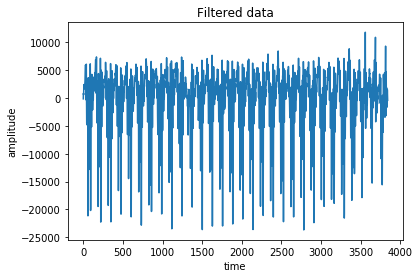

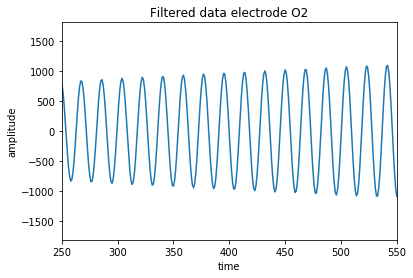

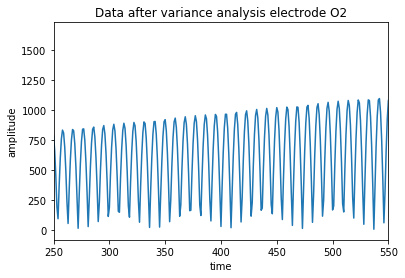

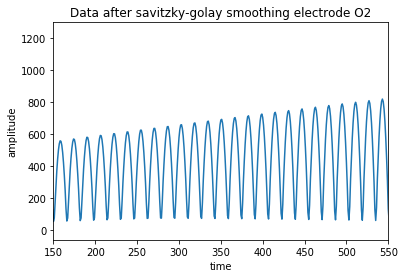

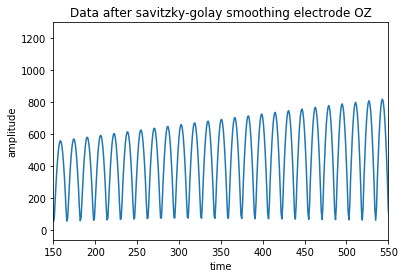

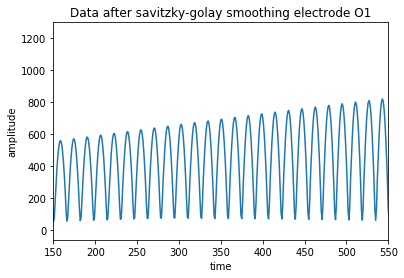

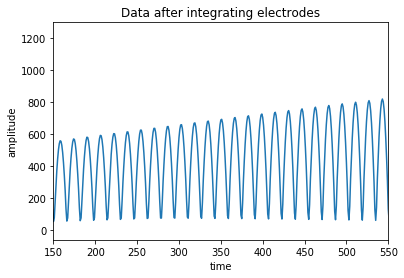

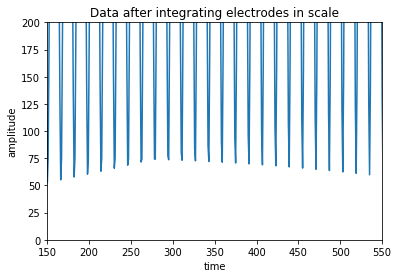

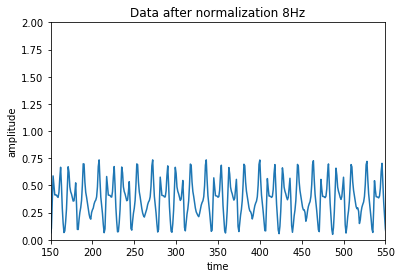

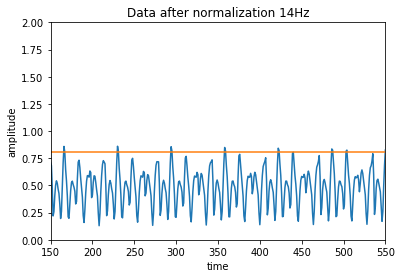

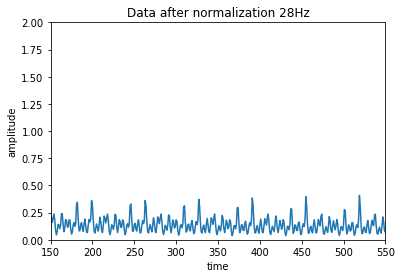

In [108]:

plt.plot(bs.ica_file.data[28])

plt.ylabel('amplitude')
plt.xlabel('time')
plt.title('Filtered data')
# plt.ylim([-15000,15000])
plt.show()



plt.plot(bs.s_14Hz[2])
plt.xlim([250,550])
# plt.ylim([260,290])
plt.ylabel('amplitude')
plt.xlabel('time')
plt.title('Filtered data electrode O2')
plt.savefig('filtered.jpg')
# plt.ylim([-15000,15000])
plt.show()

bs.variance_analyzer()

plt.plot(bs.s_14Hz[2])
plt.xlim([250,550])
# plt.xlim([3500,5500])
# plt.ylim([260,290])
plt.ylabel('amplitude')
plt.xlabel('time')
plt.title('Data after variance analysis electrode O2')
plt.savefig('varanalysis.jpg')
# plt.ylim([-15000,15000])
plt.show()

bs.smoother()


plt.plot(bs.s_08Hz[2])
plt.xlim([150,550])
# plt.ylim([260,290])
plt.ylabel('amplitude')
plt.xlabel('time')
plt.title('Data after savitzky-golay smoothing electrode O2')
plt.savefig('smoothed.jpg')
# plt.ylim([-15000,15000])
plt.show()


plt.plot(bs.s_08Hz[1])
plt.xlim([150,550])
# plt.ylim([260,290])
plt.ylabel('amplitude')
plt.xlabel('time')
plt.title('Data after savitzky-golay smoothing electrode OZ')
# plt.ylim([-15000,15000])
plt.show()


plt.plot(bs.s_08Hz[0])
plt.xlim([150,550])
# plt.ylim([260,290])
plt.ylabel('amplitude')
plt.xlabel('time')
plt.title('Data after savitzky-golay smoothing electrode O1')
# plt.ylim([-15000,15000])
plt.show()

bs.integrator()

plt.plot(bs.s_08Hz)
plt.xlim([150,550])
# plt.ylim([260,290])
plt.ylabel('amplitude')
plt.xlabel('time')
plt.title('Data after integrating electrodes')
plt.savefig('integrated.jpg')
# plt.ylim([-15000,15000])
plt.show()


plt.plot(bs.s_08Hz)
plt.xlim([150,550])
plt.ylim([0,200])
# plt.ylim([260,290])
plt.ylabel('amplitude')
plt.xlabel('time')
plt.title('Data after integrating electrodes in scale')
# plt.ylim([-15000,15000])
plt.show()

bs.normalizer()

plt.plot(bs.s_08Hz)
plt.xlim([150,550])
plt.ylim([0,2])
# plt.ylim([260,290])
plt.ylabel('amplitude')
plt.xlabel('time')
plt.title('Data after normalization 8Hz')
plt.savefig('normalized8.jpg')
# plt.ylim([-15000,15000])
plt.show()


plt.plot(bs.s_14Hz)
plt.plot([bs.s_08Hz.max()]*len(bs.s_08Hz))
plt.xlim([150,550])
plt.ylim([0,2])
# plt.ylim([260,290])
plt.ylabel('amplitude')
plt.xlabel('time')
plt.title('Data after normalization 14Hz')
plt.savefig('normalized14.jpg')
# plt.ylim([-15000,15000])
plt.show()

plt.plot(bs.s_28Hz)
plt.xlim([150,550])
plt.ylim([0,2])
# plt.ylim([260,290])
plt.ylabel('amplitude')
plt.xlabel('time')
plt.title('Data after normalization 28Hz')
plt.savefig('normalized28.jpg')
# plt.ylim([-15000,15000])
plt.show()

Creating RawArray with float64 data, n_channels=128, n_times=6361
    Range : 0 ... 6360 =      0.000 ...    24.844 secs
Ready.
Setting up band-pass filter from 1 - 40 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 1690 samples (6.602 sec) selected


/home/stakar/Studia/kogni/Magisterka/code/bieg.py:98: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  self.raw.filter(filter[0], filter[1], n_jobs=2)


<ICA  |  no decomposition, fit (fastica):  samples, no dimension reduction>
Fitting ICA to data using 128 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.


[Parallel(n_jobs=2)]: Done 128 out of 128 | elapsed:    0.1s finished


Using all PCA components: 128


/usr/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


<ICA  |  raw data decomposition, fit (fastica): 2052 samples, 128 components, channels used: "eeg">
Creating RawArray with float64 data, n_channels=128, n_times=6361
    Range : 0 ... 6360 =      0.000 ...    24.844 secs
Ready.
Setting up band-pass filter from 1 - 40 Hz
fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 1690 samples (6.602 sec) selected


/home/stakar/Studia/kogni/Magisterka/code/bieg.py:98: DeprecationWarning: fir_design defaults to "firwin2" in 0.15 but will change to "firwin" in 0.16, set it explicitly to avoid this warning.
  self.raw.filter(filter[0], filter[1], n_jobs=2)


<ICA  |  no decomposition, fit (fastica):  samples, no dimension reduction>
Fitting ICA to data using 128 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.


[Parallel(n_jobs=2)]: Done 128 out of 128 | elapsed:    0.1s finished


Using all PCA components: 128
<ICA  |  raw data decomposition, fit (fastica): 2052 samples, 128 components, channels used: "eeg">
Transforming to ICA space (128 components)
Zeroing out 5 ICA components


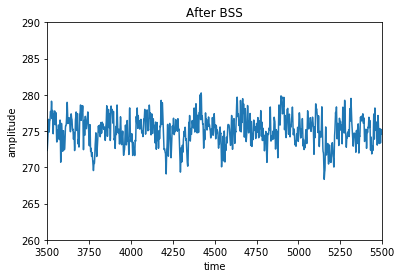

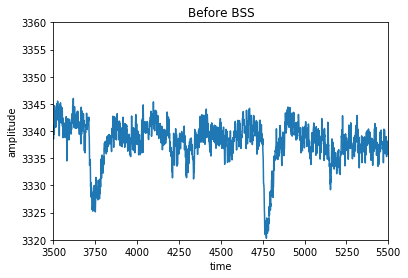

In [104]:
#wykresy z BSS na prezentację PFK

bs = BakardjianSystem(path = 'subject2/8Hz_data1.csv',seconds=5)
bs.bss_ica()

plt.plot(bs.ica_file.data[28])
plt.xlim([3500,5500])
plt.ylim([260,290])
plt.ylabel('amplitude')
plt.xlabel('time')
plt.title('After BSS')
plt.savefig('afterbss.jpg')
# plt.ylim([-15000,15000])
plt.show()

bs2 = BakardjianSystem(path = 'subject2/8Hz_data1.csv',seconds=5,extract=False)
bs2.bss_ica()
plt.plot(bs2.ica_file.data[28])
plt.xlim([3500,5500])
plt.ylim(3320,3360)
plt.ylabel('amplitude')
plt.xlabel('time')
plt.title('Before BSS')
plt.savefig('beforebss.jpg')
# plt.xlim([500,750])
# plt.xlim([0,1000])

plt.show()

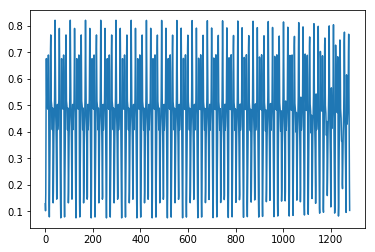